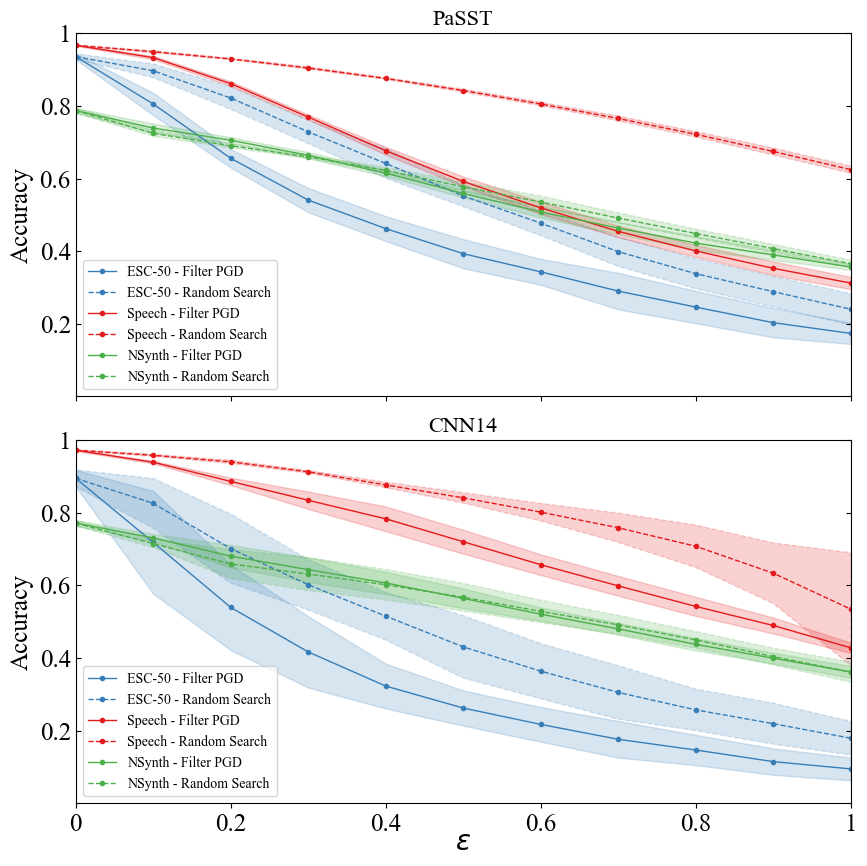

In [5]:
import wandb
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import sem, t
from tqdm import tqdm

LABELSIZE = 18
TICKSIZE = 12
LEGENDSIZE = 10
TITLESIZE = 16
plt.rcParams["font.family"] = "Times New Roman"
CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00', '#000000']
style_lookup = {
    "esc50": {
        "test/adv/accuracy": {'color': CB_color_cycle[0], 'linestyle': '-'},
        "test/rs/accuracy": {'color': CB_color_cycle[0], 'linestyle': '--'}
        },
    "SpeechCommandsV2": {
        "test/adv/accuracy": {'color': CB_color_cycle[7], 'linestyle': '-'},
        "test/rs/accuracy": {'color': CB_color_cycle[7], 'linestyle': '--'}
        },
    "nsynth": {
        "test/adv/accuracy": {'color': CB_color_cycle[2], 'linestyle': '-'},
        "test/rs/accuracy": {'color': CB_color_cycle[2], 'linestyle': '--'}
        },
}

label_lookup = {
    "esc50": "ESC-50",
    "SpeechCommandsV2": "Speech",
    "nsynth": "NSynth",
    "test/adv/accuracy": "Filter PGD",
    "test/rs/accuracy": "Random Search"
}

def get_acc(run, acc_key: str = "test/adv/accuracy"):
    history_adv = run.scan_history(keys = ["trainer/global_step", acc_key])
    adv_acc = [(row["trainer/global_step"], row[acc_key]) for row in history_adv][:10]
    # dumb hotfix
    if run.id == '60233468':
        adv_acc[0] = (0.1, adv_acc[0][1])
    history_clean = run.scan_history(keys = ["test/clean/accuracy"])
    clean_acc = [row["test/clean/accuracy"] for row in history_clean][0]
    
    adv_acc = sorted(adv_acc, key=lambda x: x[0])
    adv_acc = np.array([tup[1] for tup in adv_acc])
    if len(adv_acc) < 10:
        return
    clean_acc = np.array(clean_acc)
    acc = np.hstack([clean_acc, adv_acc])
    return acc

def plot_runs(runs, ax, dataset: str, acc_key: str, model=None, acc_cached = None):
    tags = set([dataset, "final", "baseline"])
    if model is not None:
        tags.add(model)
    final_runs = [
        run for run in runs if tags.issubset(set(run.tags))
    ]
    xs = np.arange(0, 1.1, 0.1)
    if acc_cached is not None:
        ys = acc_cached
    else:
        ys = [get_acc(run, acc_key) for run in tqdm(final_runs, f"Reading runs for {dataset} {acc_key} {model}")]
        ys = np.array([y for y in ys if y is not None])
    mean_ys = ys.mean(axis=0)
    n = ys.shape[0]
    confidence = 0.95
    h = sem(ys, axis=0) * t.ppf((1 + confidence) / 2., n-1)

    ax.plot(xs, mean_ys, label=label_lookup[dataset] + " - " + label_lookup[acc_key], 
            linestyle=style_lookup[dataset][acc_key]['linestyle'], 
            linewidth=1, marker='.',
            color=style_lookup[dataset][acc_key]['color'])
    
    ax.fill_between(xs, mean_ys - h, mean_ys + h, color=style_lookup[dataset][acc_key]['color'], alpha=0.2,
                    linestyle=style_lookup[dataset][acc_key]['linestyle'])
    return ys

api = wandb.Api()
runs = api.runs("dettmer-rwth-aachen-university/openmic_advtrain")

fig, ax = plt.subplots(nrows=2, figsize=(10, 10), sharex=True)
if 'ys_passt' not in locals():
    ys_passt = [None] * 6
ys_passt = [plot_runs(runs, ax[0], "esc50", "test/adv/accuracy", model="PaSST", acc_cached=ys_passt[0]),
      plot_runs(runs, ax[0], "esc50", "test/rs/accuracy", model="PaSST", acc_cached=ys_passt[1]),
      plot_runs(runs, ax[0], "SpeechCommandsV2", "test/adv/accuracy", model="PaSST", acc_cached=ys_passt[2]),
      plot_runs(runs, ax[0], "SpeechCommandsV2", "test/rs/accuracy", model="PaSST", acc_cached=ys_passt[3]),
      plot_runs(runs, ax[0], "nsynth", "test/adv/accuracy", model="PaSST", acc_cached=ys_passt[4]),
      plot_runs(runs, ax[0], "nsynth", "test/rs/accuracy", model="PaSST", acc_cached=ys_passt[5])]
ax[0].set_xlim(0, 1)
ax[0].set_ylim(0, 1)
ax[0].set_ylabel("Accuracy", fontsize=LABELSIZE)
ticks = np.arange(0.2, 1.1, 0.2)
ax[0].set_yticks(ticks)
ax[0].yaxis.set_ticks_position('both')
ax[0].yaxis.set_tick_params(labelright=False, labelleft=True)
ax[0].tick_params(axis='y', which='both', right=True, direction='in', labelright=False, labelsize=LABELSIZE)
ax[0].set_title("PaSST", fontsize=TITLESIZE)
ax[0].legend(fontsize=LEGENDSIZE)

if 'ys_cnn' not in locals():
    ys_cnn = [None] * 6
ys_cnn = [plot_runs(runs, ax[1], "esc50", "test/adv/accuracy", model="CNN14", acc_cached=ys_cnn[0]),
      plot_runs(runs, ax[1], "esc50", "test/rs/accuracy", model="CNN14", acc_cached=ys_cnn[1]),
      plot_runs(runs, ax[1], "SpeechCommandsV2", "test/adv/accuracy", model="CNN14", acc_cached=ys_cnn[2]),
      plot_runs(runs, ax[1], "SpeechCommandsV2", "test/rs/accuracy", model="CNN14", acc_cached=ys_cnn[3]),
      plot_runs(runs, ax[1], "nsynth", "test/adv/accuracy", model="CNN14", acc_cached=ys_cnn[4]),
      plot_runs(runs, ax[1], "nsynth", "test/rs/accuracy", model="CNN14", acc_cached=ys_cnn[5])]
ax[1].set_xlim(0, 1)
ax[1].set_ylim(0, 1)
ax[1].set_xlabel(r"$\epsilon$", fontsize=LABELSIZE+2)
ax[1].set_ylabel("Accuracy", fontsize=LABELSIZE)
ticks = np.arange(0.2, 1.1, 0.2)
plt.xticks(fontsize=TICKSIZE)
plt.yticks(fontsize=TICKSIZE)
ax[1].set_yticks(ticks)
ax[1].yaxis.set_ticks_position('both')
ax[1].yaxis.set_tick_params(labelright=False, labelleft=True, labelsize=LABELSIZE)
ax[1].xaxis.set_tick_params(labelsize=LABELSIZE)
ax[1].tick_params(axis='y', which='both', right=True, direction='in', labelright=False)
ax[1].set_title("CNN14", fontsize=TITLESIZE)
ax[1].legend(fontsize=LEGENDSIZE)
ax[1].xaxis.labelpad = -5

from matplotlib.ticker import FuncFormatter

# Remove ".0" from tick labels for x-axis and y-axis
def format_tick_label(x, pos):
    label = f"{x:g}"
    return label

for axis in ax:
    axis.xaxis.set_major_formatter(FuncFormatter(format_tick_label))
    axis.yaxis.set_major_formatter(FuncFormatter(format_tick_label))

plt.subplots_adjust(hspace=0.12)
plt.savefig("baselines.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [9]:
import pickle
with open('ys_passt.pkl', 'wb') as f:
    pickle.dump(ys_passt, f)
with open('ys_cnn.pkl', 'wb') as f:
    pickle.dump(ys_cnn, f)

In [20]:
import pickle
with open('ys_passt.pkl', 'rb') as f:
    ys_passt = pickle.load(f)
with open('ys_cnn.pkl', 'rb') as f:
    ys_cnn = pickle.load(f)

In [2]:
import numpy as np
np.array(ys_passt).shape

(6, 10, 11)

loading nsynth: 100%|██████████| 10/10 [00:30<00:00,  3.04s/it]


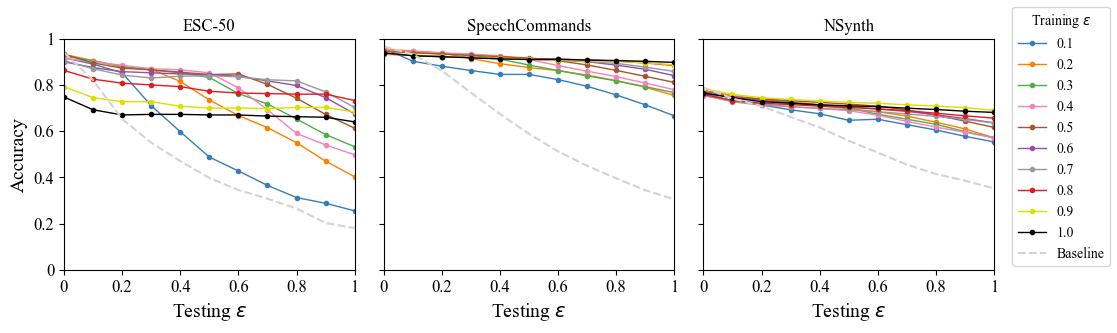

In [8]:
from tqdm import tqdm
LABELSIZE = 14
TICKSIZE = 12
LEGENDSIZE = 10
plt.rcParams["font.family"] = "Times New Roman"
CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00', '#000000']
style_lookup = {
    "esc50": {
        "test/adv/accuracy": {'color': CB_color_cycle[0], 'linestyle': '-'},
        "test/rs/accuracy": {'color': CB_color_cycle[0], 'linestyle': '--'}
        },
    "SpeechCommandsV2": {
        "test/adv/accuracy": {'color': CB_color_cycle[7], 'linestyle': '-'},
        "test/rs/accuracy": {'color': CB_color_cycle[7], 'linestyle': '--'}
        },
    "nsynth": {
        "test/adv/accuracy": {'color': CB_color_cycle[2], 'linestyle': '-'},
        "test/rs/accuracy": {'color': CB_color_cycle[2], 'linestyle': '--'}
        },
}
def get_adv_acc(run, acc_key: str = "test/adv/accuracy"):
    history_adv = run.scan_history(keys = ["trainer/global_step", acc_key])
    adv_acc = [(row["trainer/global_step"], row[acc_key]) for row in history_adv][-10:]
    # dumb hotfix
    if run.id == '60233468':
        adv_acc[0] = (0.1, adv_acc[0][1])
    history_clean = run.scan_history(keys = ["test/clean/accuracy"])
    clean_acc = [row["test/clean/accuracy"] for row in history_clean][0]
    adv_acc = sorted(adv_acc, key=lambda x: x[0])
    adv_acc = np.array([tup[1] for tup in adv_acc])
    if len(adv_acc) < 10:
        return
    clean_acc = np.array(clean_acc)
    acc = np.hstack([clean_acc, adv_acc])
    return acc

def plot_adv_runs(runs, ax, dataset: str, acc_key: str, acc_cached = None):
    final_runs = [
        run for run in runs if set([dataset, "final", "advtrain"]).issubset(set(run.tags))
    ]
    final_runs = sorted(final_runs, key=lambda r: float(r.name.split('-')[-1][3:]))
    xs = np.arange(0, 1.1, 0.1) 
    if acc_cached is not None:
        ys = acc_cached
    else:
        try:
            ys = [get_adv_acc(run, acc_key) for run in tqdm(final_runs, f"loading {dataset}")]
            ys = np.array([y for y in ys if y is not None])

        except Exception as e:
            print(f"Error loading runs for {dataset}: {e}")
            return None
        
    for i, y in enumerate(ys):
        eps = final_runs[i].name.split('-')[-1][3:]
        ax.plot(xs, y,
                linestyle=style_lookup[dataset][acc_key]['linestyle'], 
                linewidth=1, marker='.',
                color=CB_color_cycle[int(float(eps)*10 - 1)],
                label=eps)
    return ys

api = wandb.Api()
runs = api.runs("dettmer-rwth-aachen-university/openmic_advtrain")

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 3), sharey=True)

if 'ys_adv' not in locals():
    ys_adv = [None] * 3
ys_adv = [plot_adv_runs(runs, ax[0], "esc50", "test/adv/accuracy", acc_cached=ys_adv[0]),
      plot_adv_runs(runs, ax[1], "SpeechCommandsV2", "test/adv/accuracy", acc_cached=ys_adv[1]),
      plot_adv_runs(runs, ax[2], "nsynth", "test/adv/accuracy", acc_cached=ys_adv[2])]

ticks = np.arange(0, 1.1, 0.2)
ax[0].set_ylabel("Accuracy", fontsize=LABELSIZE)
ax[0].set_title("ESC-50")
ax[1].set_title("SpeechCommands")
ax[2].set_title("NSynth")
#ax[0].legend(fontsize=8, title=r"Training $\epsilon$", ncol=2)
for axis in ax:
    axis.set_xlim(0, 1)
    axis.set_ylim(0, 1)
    axis.set_xlabel(r"Testing $\epsilon$", fontsize=LABELSIZE)
    axis.set_xticks(ticks)
    axis.tick_params(axis='both', which='major', labelsize=TICKSIZE)
    
# Add median baselines
xs = np.arange(0, 1.1, 0.1)
for i, idx in enumerate([0, 2, 4]):
    if ys_passt[idx] is not None:
        median = np.median(ys_passt[idx], axis=0)
        ax[i].plot(xs, median, linestyle='--', color='lightgray', label='Baseline')
        #ax[i].legend(fontsize=8, title=r"$\epsilon$", ncol=2)
handles, labels = ax[0].get_legend_handles_labels()

from matplotlib.ticker import FuncFormatter

# Remove ".0" from tick labels for x-axis and y-axis
def format_tick_label(x, pos):
    label = f"{x:g}"
    return label

for axis in ax:
    axis.xaxis.set_major_formatter(FuncFormatter(format_tick_label))
    axis.yaxis.set_major_formatter(FuncFormatter(format_tick_label))
fig.subplots_adjust(wspace=0.1)#, right=0.82)
fig.legend(handles, labels, fontsize=LEGENDSIZE, title=r"Training $\epsilon$", ncol=1)
plt.savefig("advtrain.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [13]:
import pickle
with open('ys_adv.pkl', 'wb') as f:
    pickle.dump(ys_adv, f)

In [13]:
import pickle
with open('ys_adv.pkl', 'rb') as f:
    ys_adv = pickle.load(f)

## Statistical testing

In [7]:
from scipy.stats import wilcoxon
def run_wilcoxon(res_pgd, res_rnd):
    stat, p_value = wilcoxon(res_pgd, res_rnd, alternative='less')
    print(f"Wilcoxon signed-rank test statistic: {stat}")
    print(f"P-value: {p_value}")

ys_passt = np.array(ys_passt)
ys_cnn = np.array(ys_cnn)

for i in range(3):
    print(f"Dataset: {['ESC-50', 'SpeechCommands', 'NSynth'][i]}")
    print("PaSST:")
    res_pgd = np.concatenate(ys_passt[i*2, :, 1:], axis=0)
    res_rnd = np.concatenate(ys_passt[i*2+1, :, 1:], axis=0)
    run_wilcoxon(res_pgd, res_rnd)
    print("CNN14:")
    res_pgd = np.concatenate(ys_cnn[i*2, :, 1:], axis=0)
    res_rnd = np.concatenate(ys_cnn[i*2+1, :, 1:], axis=0)
    run_wilcoxon(res_pgd, res_rnd)
    print("----------------------------------")


Dataset: ESC-50
PaSST:
Wilcoxon signed-rank test statistic: 0.0
P-value: 3.7690770774972347e-10
CNN14:
Wilcoxon signed-rank test statistic: 0.0
P-value: 5.528299826972799e-10
----------------------------------
Dataset: SpeechCommands
PaSST:
Wilcoxon signed-rank test statistic: 0.0
P-value: 3.77675632193688e-10
CNN14:
Wilcoxon signed-rank test statistic: 9.0
P-value: 2.930988785010413e-14
----------------------------------
Dataset: NSynth
PaSST:
Wilcoxon signed-rank test statistic: 341.0
P-value: 0.0021030225585542154
CNN14:
Wilcoxon signed-rank test statistic: 685.5
P-value: 0.7661342405752858
----------------------------------
